In [1]:
!pip install numpy==1.16.1
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from sklearn.model_selection import train_test_split

import os
tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
filename = "test_gemini_BTCUSD_Close_2H_LWS3_IWS20_Trf['RP', 'GADF', 'MTF'].npz"

### Image window sizes

In [4]:
Image_window_size = np.int(filename[filename.find('_IWS') + 4 : filename.find("_Trf")])
Image_window_size

20

### Transformation types

In [5]:
Image_trf = eval(filename[filename.find('_Trf')+4:filename.find('.npz')])
Image_trf

['RP', 'GADF', 'MTF']

In [6]:
num_color_channels = len(Image_trf)
num_color_channels

3

In [0]:
data = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + filename)

In [0]:
images = data['images']
image_labels = data['image_labels']
label_names = data['label_names']

# Check data

In [0]:
# for quick check: only 1000 images
# images = images[:1000]
# image_labels = image_labels[:1000]

In [10]:
images.shape

(3, 12575, 20, 20)

In [11]:
image_labels.shape

(12575, 3)

In [12]:
print("max: {}; min: {}".format(np.amax(images), np.amin(images)))

max: 1.0; min: 0.0


In [13]:
label_names = label_names.item()
label_names

{0: 'Buy', 1: 'Hold', 2: 'Sell'}

## e.g.:

Transformation type: RP


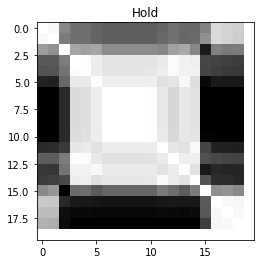

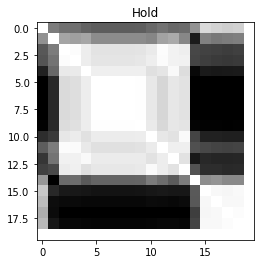

Transformation type: GADF


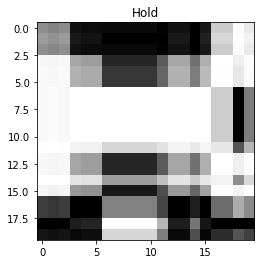

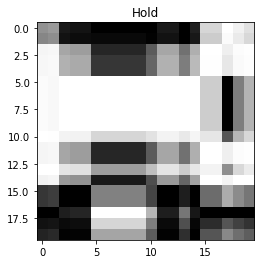

Transformation type: MTF


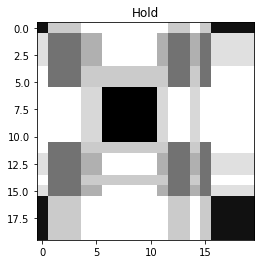

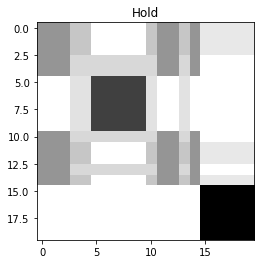

In [14]:
for trfidx, trf in enumerate(Image_trf):
    print('Transformation type: ' + trf)
    for idx, image in enumerate(images[trfidx,:2,:,:]):
        plt.imshow(image, cmap = "Greys")
        plt.title(label_names[np.int(np.argwhere(image_labels[idx]))])
        plt.show()

## Baseline
Choosing the biggest class to be the class of all gives the accuracy of:

In [15]:
baseline = np.max(np.sum(image_labels, 0))/np.sum(image_labels)
baseline

0.4842942345924453

In [0]:
baseline_balanced = 1/num_color_channels #http://mvpa.blogspot.com/2015/12/balanced-accuracy-what-and-why.html

In [17]:
np.sum(image_labels, axis = 0)/np.sum(image_labels)

array([0.26091451, 0.48429423, 0.25479125])

## Reshape

In [0]:
images = np.moveaxis(images,0,-1)

In [19]:
print("Images shape : {}; Labels shape : {}".format(images.shape, image_labels.shape))

Images shape : (12575, 20, 20, 3); Labels shape : (12575, 3)


**The shape we need:**

Images shape : (obs, image_dim, image_dim, num_color_channels); Labels shape : (obs, num_classes)

# to check
for trfidx, trf in enumerate(Image_trf):
    print('Transformation type: ' + trf)
    for idx, image in enumerate(images[:2,:,:,trfidx]):
        plt.imshow(image, cmap = "Greys")
        plt.title(label_names[np.int(np.argwhere(image_labels[idx]))])
        plt.show()

# Train - test split without overlap

In [0]:
images_train, images_test, image_labels_train, image_labels_test = train_test_split(images, 
                                                                                    image_labels, 
                                                                                    test_size = .2, 
                                                                                    random_state = 22
                                                                                   )

## We need to get rid of the first (Image Window Size -1) test data to avoid lookahead bias.

In [0]:
images_test = images_test[(Image_window_size-1):]
image_labels_test = image_labels_test[(Image_window_size-1):]

In [22]:
print("Train images shape : {}; Train labels shape : {}".format(images_train.shape, image_labels_train.shape))

Train images shape : (10060, 20, 20, 3); Train labels shape : (10060, 3)


In [23]:
print("Test images shape : {}; Test labels shape : {}".format(images_test.shape, image_labels_test.shape))

Test images shape : (2496, 20, 20, 3); Test labels shape : (2496, 3)


# The Deep CNN

## Hyperparameter settings

In [0]:
training_iters = 120
learning_rate = 0.001
batch_size = 128

### Network Parameters

In [0]:
# image shape (d x d)
n_input = images_train.shape[1]

# number of classes
n_classes =  image_labels_train.shape[1]

# dropout
dropout = 0.8 # prob. to keep 

In [0]:
# placeholders float type
#input placeholder
x = tf.placeholder("float", [None, n_input, n_input, num_color_channels])

# output placeholder
y = tf.placeholder("float", [None, n_classes])

# dropout
keep_prob = tf.placeholder(tf.float32)

### Wrappers

Because using conv layer multiple times, we define it as a function (strides should be 1 for the first and last (how the convolution filter strides through picture: sliding 1 pixel at once, etc.))

In [0]:
def conv2d(x, W, b, strides = 1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides =[1, strides, strides, 1], padding = 'SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) # activation ReLu

In [0]:
def conv3d(x, W, b, strides = 1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides =[1, strides, strides, strides, 1], padding = 'SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) # activation ReLu

In [0]:
def maxpool2d(x, k = 2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [0]:
def maxpool3d(x, k = 2):
    return tf.nn.max_pool(x, ksize = [1, k, k, k, 1], strides = [1, k, k, k, 1], padding = 'SAME')

In [0]:
def avgpool2d(x, k = 2):
    return tf.nn.avg_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')

In [0]:
def avgpool3d(x, k = 2):
    return tf.nn.avg_pool(x, ksize = [1, k, k, k, 1], strides = [1, k, k, k, 1], padding = 'SAME')

### Initialization of weights, biases

Xavier initialization: Xavier Glorot & Yoshua Bengio (2010), designed to keep the scale of the gradients roughly the same in all layers.

Defining dimension - multiplier for weights of fully connected layer

In [0]:
poolsize1 = 2
poolsize2 = 2
poolsize3 = 2

fc_dim = np.int(np.ceil(np.ceil(np.ceil(n_input/poolsize1)/poolsize2)/poolsize3))

In [34]:
weights = {
    # (kernel, kernel, input, output)
    'wc1' : tf.get_variable('W0', shape = (3, 3, num_color_channels,  32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2' : tf.get_variable('W1', shape = (3, 3, 32, 64), initializer=tf.contrib.layers.xavier_initializer()),
    'wc3' : tf.get_variable('W2', shape = (3, 3, 64, 128), initializer=tf.contrib.layers.xavier_initializer()),
    'wd1' : tf.get_variable('W3', shape = (fc_dim*fc_dim*128, 128), initializer=tf.contrib.layers.xavier_initializer()), #depends on image size
    'out' : tf.get_variable('W4', shape = (128, n_classes), initializer=tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1' : tf.get_variable('B0', shape = (32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2' : tf.get_variable('B1', shape = (64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3' : tf.get_variable('B2', shape = (128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1' : tf.get_variable('B3', shape = (128), initializer=tf.contrib.layers.xavier_initializer()),
    'out' : tf.get_variable('B4', shape = (n_classes), initializer=tf.contrib.layers.xavier_initializer())
}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


### Network Build

In [0]:
def conv_net(x, weights, biases, dropout):
    # here we call conv2d fct. and pass input image x, weights wc1, bias bc1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a 10*10 matrix (ceil(image_size/2))
    conv1 = maxpool2d(conv1, k = poolsize1) # could be maxpooling
    
    # Convolution layer
    
    # call conv2d, pass input conv1, weights wc2, biases bc2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a ceil(conv1_len/2) * ceil(conv1_len/2)  matrix
    conv2 = maxpool2d(conv2, k = poolsize2)
    
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Avg. pooling (down-sampling), this chooses the avg value of a 2*2 matrix window and outputs a ceil(conv2_len/2)*ceil(conv2_len/2) matrix
    conv3 = maxpool2d(conv3, k = poolsize3)
    
    
    # Fully Connected Layer (Dense)
    # REshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
     # Apply Dropout
    fc1 = tf.nn.dropout(fc1, rate=(1-dropout))
    
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and bias term for the out
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
    return out

### Loss and Optimizer Nodes

Loss funciton here is cross entropy, with the reasoning that it's a fitting loss function due to always being positive and tending towards zero if the neuron gets better in guessing the right label and because it recovers faster from wrong intializations and the learning doesnt slow down

Avg. loss over batches to get a  single loss - maybe weighted

In [0]:
pred = conv_net(x, weights, biases, keep_prob)

# your class weights
class_weights = tf.constant([np.ndarray.tolist(np.sum(image_labels, axis = 0)/np.sum(image_labels))])
# class_weights = tf.constant([[.3, .3, .3]])
# deduce weights for batch samples based on their true label
weights = tf.reduce_sum(class_weights * y, axis=1)
# compute your (unweighted) softmax cross entropy loss
unweighted_losses = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits = pred)
# apply the weights, relying on broadcasting of the multiplication
weighted_losses = unweighted_losses * weights
# reduce the result to get your final loss
cost = tf.reduce_mean(weighted_losses)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

### Evaluate Model Node

U can save a graph and run testing on it later

ACCURACY CAN BE CHANGED TO OTHER MEASURE LATER

In [0]:
# Check whether the index of the maximum value of the predicted image is equal to the actual labelled image - both will be a column vector
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Calculate accuracy across all given images and average them
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
# Initializing the vars
init = [tf.global_variables_initializer(), tf.local_variables_initializer()]


## Training and testing

In [39]:
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(np.int(np.ceil(len(images_train)/batch_size))):
            batch_x = images_train[batch*batch_size : min((batch+1)*batch_size, len(images_train))]
            batch_y = image_labels_train[batch*batch_size : min((batch+1)*batch_size, len(image_labels_train))]
            
            # Run optimization op (backprop)
            # Calculate batch loss and accuracy
            sess.run(optimizer, feed_dict = {x : batch_x, y : batch_y, keep_prob: dropout})
            
            loss, acc = sess.run([cost, accuracy], feed_dict = {x : batch_x,
                                                                y : batch_y,
                                                                keep_prob: 1.})
        print("Iter " + str(i) + ", Loss = " + \
              "{:.6f}".format(loss) + ", Training F1 Accuracy = " + \
              "{:.5f}".format(acc)
             )
        print('Optimization Finished!')

        # Calculate accuracy for all test images
        test_acc, valid_loss = sess.run([accuracy, cost], feed_dict = {x : images_test,
                                                                       y : image_labels_test,
                                                                       keep_prob: 1.})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print('Testing F1 Accuracy: ', "{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss = 0.303849, Training F1 Accuracy = 0.46053
Optimization Finished!
Testing F1 Accuracy:  0.48958
Iter 1, Loss = 0.254814, Training F1 Accuracy = 0.46053
Optimization Finished!
Testing F1 Accuracy:  0.48958
Iter 2, Loss = 0.250625, Training F1 Accuracy = 0.46053
Optimization Finished!
Testing F1 Accuracy:  0.48958
Iter 3, Loss = 0.245494, Training F1 Accuracy = 0.46053
Optimization Finished!
Testing F1 Accuracy:  0.48998
Iter 4, Loss = 0.241346, Training F1 Accuracy = 0.46053
Optimization Finished!
Testing F1 Accuracy:  0.48958
Iter 5, Loss = 0.238333, Training F1 Accuracy = 0.46053
Optimization Finished!
Testing F1 Accuracy:  0.48918
Iter 6, Loss = 0.233420, Training F1 Accuracy = 0.48684
Optimization Finished!
Testing F1 Accuracy:  0.48518
Iter 7, Loss = 0.233673, Training F1 Accuracy = 0.48684
Optimization Finished!
Testing F1 Accuracy:  0.48678
Iter 8, Loss = 0.229018, Training F1 Accuracy = 0.48684
Optimization Finished!
Testing F1 Accuracy:  0.48638
Iter 9, Loss = 0.22